# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

# 1. Подготовка данных

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
RowNumber          10000 non-null int64
CustomerId         10000 non-null int64
Surname            10000 non-null object
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             9091 non-null float64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


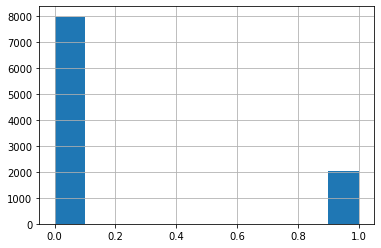

In [ ]:
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'


data = pd.read_csv('/datasets/Churn.csv') # Создаем исходную выборку
data.info()
data.head(5)

data['Exited'].hist()

### Промежуточный вывод
- Исходные данные прочитаны 
- Размер исходных данных: (10.000 строк на 14 колонок)
- Пропуски в стобце Tenure 
- Не нужные для целей анализа столбцы RowNumber, CustomerID, Surname
- Требуется прямое кодирование (OHE) в столбцах Geography и  Gender
- Требуется масштабирование
- явный дисбаланс классов 

In [ ]:
data['Tenure'] = data['Tenure'].fillna(data['Tenure'].median()) # Заполняем пропуски медианой
data = data.drop(['RowNumber', 'CustomerId', 'Surname'], axis = 1) # Убираем ненужные столбцы 
data_ohe = pd.get_dummies(data, drop_first = True) # Преобразовываем категориальные признаки в численные при помощи OHE

data_ohe.info()
data_ohe.head(5)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
CreditScore          10000 non-null int64
Age                  10000 non-null int64
Tenure               10000 non-null float64
Balance              10000 non-null float64
NumOfProducts        10000 non-null int64
HasCrCard            10000 non-null int64
IsActiveMember       10000 non-null int64
EstimatedSalary      10000 non-null float64
Exited               10000 non-null int64
Geography_Germany    10000 non-null uint8
Geography_Spain      10000 non-null uint8
Gender_Male          10000 non-null uint8
dtypes: float64(3), int64(6), uint8(3)
memory usage: 732.5 KB


,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
0,619,42,2.0,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1.0,83807.86,1,0,1,112542.58,0,0,1,0
2,502,42,8.0,159660.80,3,1,0,113931.57,1,0,0,0
3,699,39,1.0,0.00,2,0,0,93826.63,0,0,0,0
4,850,43,2.0,125510.82,1,1,1,79084.10,0,0,1,0


### Промежуточный вывод
- Удалены столбцы RowNumber, CustomerID, Surname так как эти столбцы не особо нужны для обучения
- Пропуски в столбце Tenure были заполнены медианой, так как данный способ самый предпочтительный для обучения моделей
- Категориальные признаки были преобразованны в численные при помощи OHE 
- Итоговый размер таблицы 10.000 строк на 12 колонок
- целевой признак Exited -> модель классификации

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

train_data, test_data  = train_test_split(data_ohe, test_size = 1/5, random_state = 12345)

target = train_data['Exited']   # столбец с целевым признаком
features = train_data.drop('Exited', axis = 1) # стоблец с признаками 

train_target, valid_target, train_features, valid_features = train_test_split(target, features, test_size = 0.2, random_state = 12345)


numeric = ['CreditScore', 'Age', 'Tenure', 'Balance', 'EstimatedSalary'] # числовые столбцы для масштабирования 
scaler = StandardScaler()  # Проводим процесс масштабирования 
scaler.fit(train_features[numeric])
train_features[numeric] = scaler.transform(train_features[numeric])
valid_features[numeric] = scaler.transform(valid_features[numeric])

### Промежуточный вывод
- Данные были разделены на три выборки: обучающая, валидационная и тестовая (соотношение 3:1:1)
- Количесвтенные признаки были промасштабированы 

# 2. Исследование моделей

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score, recall_score, precision_score, roc_auc_score

# Изучаем модель Tree


depths = []
f1_metrics = []
roc_auc = []
for depth in range(2,16,1):
    model = DecisionTreeClassifier( random_state = 12345, max_depth = depth)
    model.fit(train_features, train_target)
    predicted = model.predict(valid_features)
    predicted_proba = model.predict_proba(valid_features)
    probabilities_one_valid = predicted_proba[:, 1]
    f1 = f1_score(valid_target,predicted)
    depths.append(depth)
    f1_metrics.append(f1)
    roc = roc_auc_score(valid_target, probabilities_one_valid)
    roc_auc.append(roc)
    
tree_metrics = pd.DataFrame(
                            {'depth' : depths,
                             'f1_score' : f1_metrics,
                             'roc_auc' : roc_auc
                            })

print('Лучшая глубина для Tree модели равна 5')
tree_metrics

Лучшая глубина для Tree модели равна 5


,depth,f1_score,roc_auc
0,2,0.508539,0.745583
1,3,0.392157,0.798654
2,4,0.436451,0.812114
3,5,0.564299,0.830183
4,6,0.517699,0.813269
5,7,0.553971,0.812030
6,8,0.525896,0.788471
7,9,0.522593,0.755204
8,10,0.529981,0.740037
9,11,0.529851,0.723810


In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Изучаем модель Random Forest


depths = []
f1_metrics = []
roc_auc = []

for depth in range(2,16,1):
    model = RandomForestClassifier(n_estimators= 100, max_depth=depth, random_state=12345)
    model.fit(train_features, train_target)
    predicted = model.predict(valid_features)
    predicted_proba = model.predict_proba(valid_features)
    probabilities_one_valid = predicted_proba[:, 1]
    f1 = f1_score(valid_target,predicted)
    depths.append(depth)
    f1_metrics.append(f1)
    roc = roc_auc_score(valid_target, probabilities_one_valid)
    roc_auc.append(roc)

forest_metrics = pd.DataFrame(
                            {'depth' : depths,
                             'f1_score' : f1_metrics,
                             'roc_auc' : roc_auc
                            })


print('Лучшая глубина для Forest модели равна 12')
forest_metrics

Лучшая глубина для Forest модели равна 12


,depth,f1_score,roc_auc
0,2,0.169184,0.809008
1,3,0.288889,0.822085
2,4,0.377261,0.834581
3,5,0.467470,0.845859
4,6,0.531868,0.849559
5,7,0.535332,0.854834
6,8,0.547771,0.857203
7,9,0.561331,0.857674
8,10,0.554167,0.855340
9,11,0.559671,0.855661


In [ ]:
from sklearn.linear_model import LogisticRegression

# Изучаем модель Логической регрессии 

model = LogisticRegression()
model.fit(train_features, train_target)
predicted = model.predict(valid_features)
predicted_proba = model.predict_proba(valid_features)
probabilities_one_valid = predicted_proba[:, 1]
print('F1- метрика: ', f1_score(valid_target,predicted), 'Roc_auc:', roc_auc_score(valid_target, probabilities_one_valid))

F1- метрика:  0.3145539906103286 Roc_auc: 0.763317735011743


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


### Промежуточный вывод:

- Были построены модели древа, случайного леса и логической регрессии 
- f1 мтерики соответственно: 0.564, 0.567 и  0.315
- roc_auc метрики соответственно: 0.83, 0.85 и 0.76
- Лушчая модель - модель случайного леса с параметром максимальной глубины 12

# 3. Борьба с дисбалансом

In [ ]:
from sklearn.utils import shuffle

def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

features_upsampled, target_upsampled = upsample(train_features, train_target, 4)

model = DecisionTreeClassifier( random_state = 12345, max_depth = 5)
model.fit(features_upsampled, target_upsampled)
predicted = model.predict(valid_features)
print('Древо F1- метрика: ', f1_score(valid_target,predicted)) 


model = RandomForestClassifier(n_estimators= 100, max_depth= 12, random_state=12345)
model.fit(features_upsampled, target_upsampled)
predicted = model.predict(valid_features)
print('Случайный лес  F1- метрика: ', f1_score(valid_target,predicted))

model = LogisticRegression()
model.fit(features_upsampled, target_upsampled)
predicted = model.predict(valid_features)
print('Логическая регрессия F1- метрика: ', f1_score(valid_target,predicted))

Древо F1- метрика:  0.5445544554455446
Случайный лес  F1- метрика:  0.598159509202454
Логическая регрессия F1- метрика:  0.4608501118568233


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [ ]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled

features_downsample, target_downsample = downsample(train_features, train_target, 0.25)

model = DecisionTreeClassifier( random_state = 12345, max_depth = 5)
model.fit(features_downsample, target_downsample)
predicted = model.predict(valid_features)
print('Древо F1- метрика: ', f1_score(valid_target,predicted)) 


model = RandomForestClassifier(n_estimators= 100, max_depth= 12, random_state=12345)
model.fit(features_downsample, target_downsample)
predicted = model.predict(valid_features)
print('Случайный лес  F1- метрика: ', f1_score(valid_target,predicted))

model = LogisticRegression()
model.fit(features_downsample, target_downsample)
predicted = model.predict(valid_features)
print('Логическая регрессия F1- метрика: ', f1_score(valid_target,predicted))


Древо F1- метрика:  0.5176715176715176
Случайный лес  F1- метрика:  0.5499383477188656
Логическая регрессия F1- метрика:  0.4754464285714286


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


### Промежуточный итог:

- был произведен баланс классов двумя способами 
- способ при котором происходит увличение положительного класса показал результаты чуть лучше 
- балансировка классов в целом положительно повлияло на качество модели

F1- метрика:  0.598159509202454 Roc_auc: 0.8529482863475245
Полнота: 0.6435643564356436 Точность: 0.5587392550143266


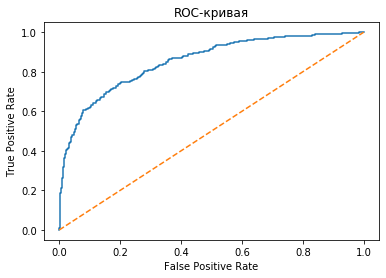

In [ ]:
# комплексны анализ выбранной модели
model = RandomForestClassifier(n_estimators= 100, max_depth= 12, random_state=12345)
model.fit(features_upsampled, target_upsampled)
predicted = model.predict(valid_features)
predicted_proba = model.predict_proba(valid_features)
probabilities_one_valid = predicted_proba[:, 1]
print('F1- метрика: ', f1_score(valid_target,predicted), 'Roc_auc:', roc_auc_score(valid_target, probabilities_one_valid))
print('Полнота:', recall_score(valid_target,predicted),'Точность:', precision_score(valid_target,predicted))



fpr, tpr, thresholds = roc_curve(valid_target, probabilities_one_valid)
plt.figure()
plt.plot(fpr,tpr, linestyle='-')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim = [0,1]
plt.ylim = [0,1]
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

### Промежуточный итог 

Модель далека от идеала, но по основному требованию проходит. F1 метрика модели > 0.59


# 4. Тестирование модели

In [ ]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

test_features = test_data.drop('Exited', axis = 1)
test_target = test_data['Exited']

test_features[numeric] = scaler.transform(test_features[numeric])

model = RandomForestClassifier(n_estimators= 100, max_depth=12, random_state=12345)
model.fit(features_upsampled, target_upsampled)
predicted = model.predict(test_features)
predicted_proba = model.predict_proba(test_features)
probabilities_one_valid = predicted_proba[:, 1]
print('F1- метрика: ', f1_score(test_target,predicted), 'Roc_auc:', roc_auc_score(test_target, probabilities_one_valid))

F1- метрика:  0.636986301369863 Roc_auc: 0.8614128047809121


### Вывод 
- Были построены модели трех видов : древа, случайного леса и логической регрессии 
- Была произведена балансировка классов с использованием двух разных методов ( увеличение положительного класса, уменьшение отрицательного класса)
- На основе показателя f1-метрика и roc-auc была выбрана модель случайного леса, метрики соотвественно:  0.60 и 0.85
- Модель была протестированна на тестовой выборке, результаты f1 метриик и roc-auc: 0.64 и  0.86 (при минимальном треб f1 метрики в 0.59)

# Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнен шаг 1: данные подготовлены
- [x]  Выполнен шаг 2: задача исследована
    - [x]  Исследован баланс классов
    - [x]  Изучены модели без учёта дисбаланса
    - [x]  Написаны выводы по результатам исследования
- [x]  Выполнен шаг 3: учтён дисбаланс
    - [x]  Применено несколько способов борьбы с дисбалансом
    - [x]  Написаны выводы по результатам исследования
- [x]  Выполнен шаг 4: проведено тестирование
- [x]  Удалось достичь *F1*-меры не менее 0.59
- [x]  Исследована метрика *AUC-ROC*